# Autoencoder vs PCA for Dimensionality Reduction

In [1]:
%matplotlib inline

In [2]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import umap

from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from numpy.linalg import svd
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [3]:
np.random.seed(1535383000)

## Dataset MNIST

(60000, 28, 28) (10000, 28, 28)


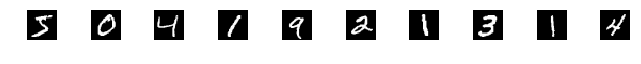

In [4]:
(X_train, y_train), (X_test, _) = mnist.load_data()

print(X_train.shape, X_test.shape)

plt.figure(figsize=(9,1))
for i in range(10):
    ax = plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i,:], interpolation='nearest')
    plt.gray()
    plt.axis('off')
    
plt.tight_layout()

X_train = X_train.reshape(60000, 784) / 255
X_test = X_test.reshape(10000, 784) / 255

## PCA

In [5]:
%%time

n_pc = 2

mu = X_train.mean(axis=0)
U, s, V = svd(X_train - mu, full_matrices=False)
Z_pca = np.dot(X_train - mu, V.T)
R_pca = np.dot(Z_pca[:, :n_pc], V[:n_pc, :]) + mu

n_rows, n_cols = R_pca.shape

#  MSE
err = np.sum((X_train - R_pca)**2) * (n_rows * n_cols)**-1

print(f'loss: {err:.4}')

loss: 0.05595
CPU times: user 24.8 s, sys: 1.34 s, total: 26.1 s
Wall time: 11.7 s


## Autoencoder

In [6]:
model = Sequential()
model.add(Dense(512, activation='elu', input_shape=(784, )))
model.add(Dense(128, activation='elu'))
model.add(Dense(2, activation='linear', name='bottleneck'))
model.add(Dense(128, activation='elu'))
model.add(Dense(512, activation='elu'))
model.add(Dense(784, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer=Adam())

model.fit(X_train, X_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_test, X_test))

encoder = Model(model.input, model.get_layer('bottleneck').output)

Z_ae = encoder.predict(X_train)
R_ae = model.predict(X_train)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 9s 150us/step - loss: 0.0568 - val_loss: 0.0492
Epoch 2/5
60000/60000 [==============================] - 8s 137us/step - loss: 0.0467 - val_loss: 0.0450
Epoch 3/5
60000/60000 [==============================] - 7s 118us/step - loss: 0.0439 - val_loss: 0.0433
Epoch 4/5
60000/60000 [==============================] - 7s 124us/step - loss: 0.0425 - val_loss: 0.0421
Epoch 5/5
60000/60000 [==============================] - 10s 161us/step - loss: 0.0414 - val_loss: 0.0410


## UMAP

In [7]:
%%time

Z_umap = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.3, metric='correlation').fit_transform(X_train)

CPU times: user 1min 24s, sys: 6.01 s, total: 1min 30s
Wall time: 1min 12s


## Embeddings

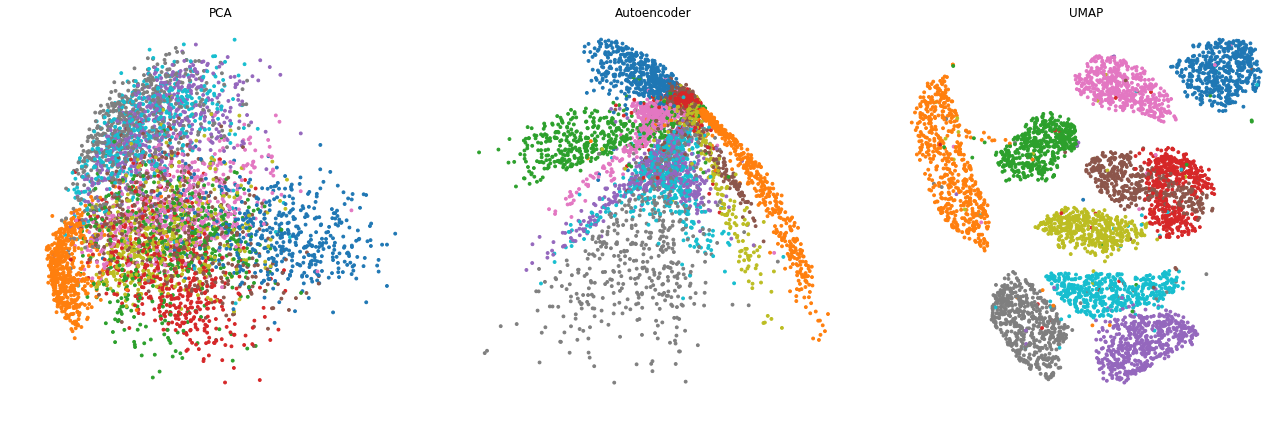

In [8]:
plt.figure(figsize=(18,6))

plt.subplot(131)
plt.title('PCA')
plt.scatter(Z_pca[:5000,0], Z_pca[:5000,1], c=y_train[:5000], s=8, cmap='tab10')
plt.axis('off')

plt.subplot(132)
plt.title('Autoencoder')
plt.scatter(Z_ae[:5000,0], Z_ae[:5000,1], c=y_train[:5000], s=8, cmap='tab10')
plt.axis('off')

plt.subplot(133)
plt.title('UMAP')
plt.scatter(Z_umap[:5000,0], Z_umap[:5000,1], c=y_train[:5000], s=8, cmap='tab10')
plt.axis('off')

plt.tight_layout()

# Reconstructing from Embeddings

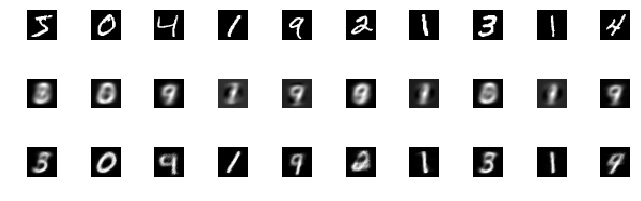

In [9]:
R_models = (X_train, R_pca, R_ae)

plt.figure(figsize=(9, 3))
for i in range(10):
    for j in range(3):
        ax = plt.subplot(3, 10, 10*j+1+i)
        plt.imshow(R_models[j][i,:].reshape(28,28), interpolation='nearest')
        plt.gray()
        plt.axis('off')
        
plt.tight_layout()

## Reference

_Reducing the Dimensionality of Data with Neuronal Networks_, G. E. Hinto & R. R. Salakhutdinov, [Science (2006)](https://www.cs.toronto.edu/~hinton/science.pdf)